# barotropic_flux
* Compare barotropic energy flux from modal decomposition and barotropic/baroclinic flux calculation
* Compare barotropic flux divergence with barotropic -> baroclinic conversion term

In [21]:
%matplotlib nbagg
import sys, os, time
from netCDF4 import Dataset, MFDataset
from xrdataset import xrdataset
import numpy as np
from matplotlib import pyplot as plt
import scipy.interpolate as itp
from scipy.ndimage.filters import gaussian_filter
import scipy.stats


In [22]:
simul = "luckym2"
tref = 500 # that's a trick
krypton = "/data0/project/vortex/lahaye/"

if simul == 'luckyto':
    chunked_mode = True
elif simul == "luckym2":
    chunked_mode = False
    
path_fluxbt = krypton+"DIAG/NRJ_fluxes/{}_bt_fluxes.0.nc".format(simul)
path_fluxbc = krypton+"DIAG/NRJ_fluxes/{}_puv_fluxes_M2.0.nc".format(simul)
if chunked_mode:
    path_mode = krypton+"{0}_modemap/{0}_mod00_nrj/{0}_mod00_nrj.0_0.nc".format(simul)
else:
    path_mode = krypton+"{0}_modemap/{0}_modenrjb.nc".format(simul)
path_grd = krypton+"lucky_corgrd.nc"

indx = None#100, 1000
indy = None#100, 1000

In [23]:
# define functions to load stuffs

def load_mode_chunked(path_mode):
    # read netCDF files, 2D+mode chunked; input is path mode with chunk number '0_0'
    # return file object
    nc = Dataset(path_mode,'r')
    npx, npy = nc.npx, nc.npy
    fmodnames = [[ path_mode.replace('0_0','{0}_{1}'.format(jy,ix)) \
                       for ix in range(npx)] for jy in range(npy)]

    nc.close()
    tmes, tmeb = time.clock(), time.time()
    nc = xrdataset(fmodnames, ['eta_rho','xi_rho'], no_mf=False)
    print("load chunked netCDF files:",time.clock()-tmes,time.time()-tmeb)
    return nc

def get_mode_chunked(nc, tref=None, indx=None, indy=None):
    # read fields from netCDF file, return dict
    tmod = nc.variables['time'][:]
    if tref is None:
        it = [0]
    else:
        it, = np.where(tmod==tref)   
    xi = nc.variables['xi_rho'][:].values
    eta = nc.variables['eta_rho'][:].values
    if indx is None:
        slix = slice(0,xi.size)
    else:
        iis, = np.where((xi>=indx[0]) & (xi<=indx[-1]))
        slix = slice(iis[0], iis[-1])
    if indy is None:
        sliy = slice(0,eta.size)
    else:
        iis, = np.where((eta>=indy[0]) & (eta<=indy[-1]))
        sliy = slice(iis[0], iis[-1])
    dico = {}
    dico["xi"] = xi[slix]
    dico['eta'] = eta[sliy]
    dico['Fxav'] = nc.variables['Fx_avg'][0,sliy,slix].values
    dico['Fyav'] = nc.variables['Fy_avg'][0,sliy,slix].values
    dico['Fxlf'] = nc.variables['Fx_lf'][it[0],0,sliy,slix].values
    dico['Fylf'] = nc.variables['Fy_lf'][it[0],0,sliy,slix].values
    dico['t'] = tmod[it[0],].values
    return dico

def get_mode_concat(nc, imod=1, tref=None, indx=None, indy=None):
    # read fields from concatenated netCDF file
    tmod = nc.variables['time'][:]
    if tref is None:
        it = [0]
    else:
        it, = np.where(tmod==tref)  
    xi = nc.variables['xi_rho'][:]
    eta = nc.variables['eta_rho'][:]
    if indx is None:
        slix = slice(0,xi.size)
    else:
        iis, = np.where((xi>=indx[0]) & (xi<=indx[-1]))
        slix = slice(iis[0], iis[-1])
    if indy is None:
        sliy = slice(0,eta.size)
    else:
        iis, = np.where((eta>=indy[0]) & (eta<=indy[-1]))
        sliy = slice(iis[0], iis[-1])
    dico = {}
    dico["xi"] = xi[slix]
    dico['eta'] = eta[sliy]
    dico['Fxav'] = nc.variables['Fx_avg'][imod,sliy,slix]
    dico['Fyav'] = nc.variables['Fy_avg'][imod,sliy,slix]
    dico['Fxlf'] = nc.variables['Fx_lf'][it[0],imod,sliy,slix]
    dico['Fylf'] = nc.variables['Fy_lf'][it[0],imod,sliy,slix]
    dico['t'] = tmod[it[0],]
    return dico

In [24]:
# load data: mode 0 and 1
mod = {}
if chunked_mode:
    ncm0 = load_mode_chunked(path_mode)
    mod[0] = get_mode_chunked(ncm0, tref, indx, indy)
    ncm1 = load_mode_chunked(path_mode.replace('00','01'))
    mod[1] = get_mode_chunked(ncm1, tref, indx, indy)
else:
    ncm = Dataset(path_mode)
    mod[0] = get_mode_concat(ncm, 0, tref, indx, indy)
    mod[1] = get_mode_concat(ncm, 1, tref, indx, indy)

xim, etam = mod[0]['xi'], mod[0]['eta']
nsxm = mod[0]['xi'][1] - mod[0]['xi'][0]
nsym = mod[0]['eta'][1] - mod[0]['eta'][0]


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater


In [25]:
##### load data: barotropic and baroclinic fluxes
# N.B: fluxes have units kW/m (hence multiply by 10^3 here)

domap = True
doint = False

# barotropic fluxes
if os.path.isfile(path_fluxbt):
    nc = Dataset(path_fluxbt,'r')
    npc = nc.nbproc
    try:
        tflu = nc.variables['time'][:]
    except:
        tflu = np.arange(nc.dimensions['time'].size) + 360
        print('WARNING: no time in file: using ad hoc, hard coded time reference')
    nc.close()
    nc = MFDataset(path_fluxbt.replace('0','?'),aggdim='eta_rho')
else:
    raise ValueError("file {} not found".format(path_flux))
it, = np.where(tflu==tref)
xif = nc.variables['xi_rho'][:]
etaf = nc.variables['eta_rho'][:]
if indx is None:
    slix = slice(0,xif.size)
else:
    iis, = np.where((xif>=indx[0]) & (xif<=indx[-1]))
    slix = slice(iis[0], iis[-1])
if indy is None:
    sliy = slice(0,etaf.size)
else:
    iis, = np.where((etaf>=indy[0]) & (etaf<=indy[-1]))
    sliy = slice(iis[0], iis[-1])
xif, etaf = xif[slix], etaf[sliy]
if domap:
    Fxbt_av = nc.variables['pubt_avg'][sliy,slix]*1e3
    Fybt_av = nc.variables['pvbt_avg'][sliy,slix]*1e3
    Fxbt_lf = nc.variables['pubt_lf'][sliy,slix,it[0]]*1e3
    Fybt_lf = nc.variables['pvbt_lf'][sliy,slix,it[0]]*1e3
    cterm = nc.variables['Ct_lf'][sliy,slix,it[0]]
if doint:
    cterm_lf, cterm_ts = np.zeros(tflu.size), np.zeros(tflu.size)
    for ii in range(sliy.start,sliy.stop):
        cterm_ts += np.nansum(nc.variables['Ct'][ii,slix,:],axis=0)
        cterm_lf += np.nansum(nc.variables['Ct_lf'][ii,slix,:],axis=0)
        if (ii%100)==1:
            print('done with ii', ii, flush=True)
nc.close()
print("done with",path_fluxbt)

# baroclinic fluxes
if os.path.isfile(path_fluxbc):
    nc = MFDataset(path_fluxbc.replace('0','?'),aggdim='eta_rho')
else:
    raise ValueError("file {} not found".format(path_flux))
if domap:
    Fxbc_av = nc.variables['puint_avg'][sliy,slix]*1e3
    Fybc_av = nc.variables['pvint_avg'][sliy,slix]*1e3
    Fxbc_lf = nc.variables['puint_lf'][sliy,slix,it[0]]*1e3
    Fybc_lf = nc.variables['pvint_lf'][sliy,slix,it[0]]*1e3
nc.close()
print("done with",path_fluxbt)

nsxf = xif[1] - xif[0]
nsyf = etaf[1] - etaf[0]

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


done with /data0/project/vortex/lahaye/DIAG/NRJ_fluxes/luckym2_bt_fluxes.0.nc


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


done with /data0/project/vortex/lahaye/DIAG/NRJ_fluxes/luckym2_bt_fluxes.0.nc


In [26]:
# load grid (on mode points)
ncg = Dataset(path_grd,'r')
pmm = ncg.variables['pm'][etam,:][:,xim]
pmn = ncg.variables['pn'][etam,:][:,xim]
pfm = ncg.variables['pm'][etaf,:][:,xif]
pfn = ncg.variables['pn'][etaf,:][:,xif]
ncg.close()
dxm, dym = nsxm/pmm.mean(), nsym/pmn.mean()
dxf, dyf = nsxf/pfm.mean(), nsyf/pfn.mean()

total barotropic energy loss: 1.0693140625e-05 GW
total mode 1 energy loss: 1.0360559082e-06 GW


<IPython.core.display.Javascript object>


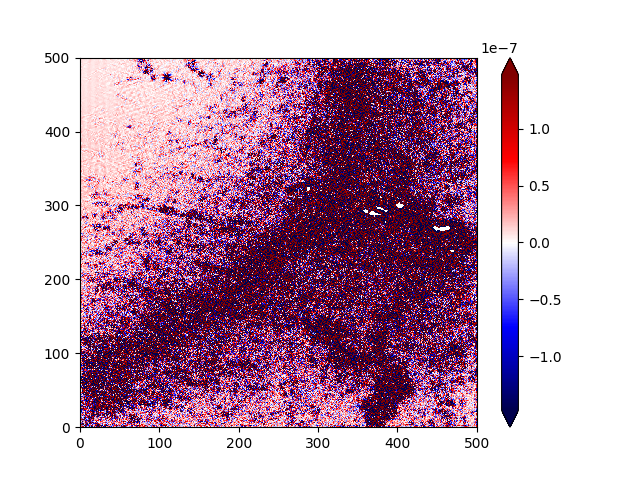

In [20]:
# plot from mod

whatplot = "divfm0"
doblur = False

divfm0 = np.gradient(mod[0]['Fxlf'], dxm, axis=1) + np.gradient(mod[0]['Fylf'], dym, axis=0)
divfm1 = np.gradient(mod[1]['Fxlf'], dxm, axis=1) + np.gradient(mod[1]['Fylf'], dym, axis=0)
modfm0 = np.sqrt(mod[0]['Fxlf']**2 + mod[0]['Fylf']**2)
modfm1 = np.sqrt(mod[1]['Fxlf']**2 + mod[1]['Fylf']**2)

if whatplot in ["divfm0", "divfm1"]:
    toplot = eval(whatplot)
    cmap = 'seismic'
    bextend = "both"
    clims = np.array([-1,1])*2*np.nanstd(toplot)/10
else:
    toplot = eval(whatplot)
    cmap = 'gist_stern_r'
    bextend = "max"
    clims = np.array([0,1])*(np.nanmean(toplot) + 2*np.nanstd(toplot))

if doblur:
    toplot = gaussian_filter(toplot, 0.5, mode='constant')
    
print("total barotropic energy loss:",np.nansum(divfm0*dxm*dym)/1e9,"GW")
print("total mode 1 energy loss:",np.nansum(divfm1*dxm*dym)/1e9,"GW")

plt.pcolormesh(toplot, vmin=clims[0], vmax=clims[1], cmap=cmap); 
plt.colorbar(extend=bextend)

total barotropic energy loss: 9.926832128 GW
total baroclinic energy loss: 2.457655296 GW
total conversion: 12.419798016 GW


<IPython.core.display.Javascript object>


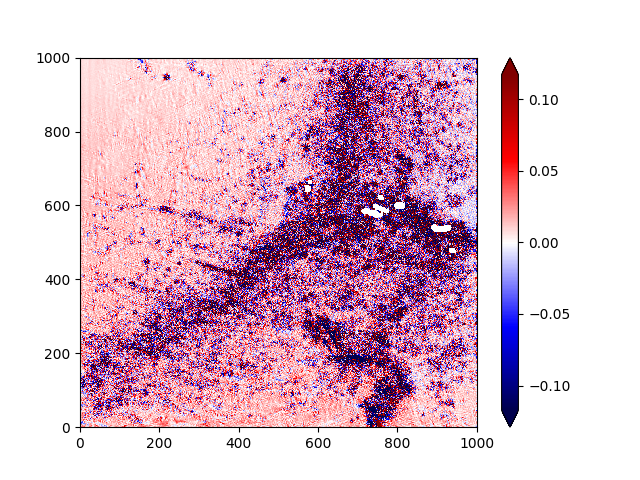

In [18]:
# plot: from flux

whatplot ="divfbt"#divfbc" #"cterm" # 
doblur = True

divfbt = np.gradient(Fxbt_lf, dxf, axis=1) + np.gradient(Fybt_lf, dyf, axis=0)
divfbc = np.gradient(Fxbc_lf, dxf, axis=1) + np.gradient(Fybc_lf, dyf, axis=0)
modfbt = np.sqrt(Fxbt_lf**2 + Fybt_lf**2)/1e3    # units kW/m
modfbc = np.sqrt(Fxbc_lf**2 + Fybc_lf**2)/1e3

toplot = eval(whatplot)
    
if whatplot in ['divfbc','divfbt','cterm']:
    cmap = 'seismic'
    bextend = "both"
    clims = np.array([-1,1])*2*np.nanstd(toplot)/10
else:
    cmap = 'gist_stern_r'
    bextend = "max"
    clims = np.array([0,1])*(np.nanmean(toplot) + 2*np.nanstd(toplot))

if doblur:
    toplot = gaussian_filter(toplot, 1, mode='constant')

print("total barotropic energy loss:", np.nansum(divfbt*dxf*dyf)/1e9, "GW")
print("total baroclinic energy loss:", np.nansum(divfbc*dxf*dyf)/1e9, "GW")
print("total conversion:", np.nansum(cterm*dxf*dyf)/1e9, "GW")

plt.pcolormesh(toplot, vmin=clims[0], vmax=clims[1], cmap=cmap); 
plt.colorbar(extend=bextend)


total diff cterm - ...: 6.84683776 GW


<IPython.core.display.Javascript object>


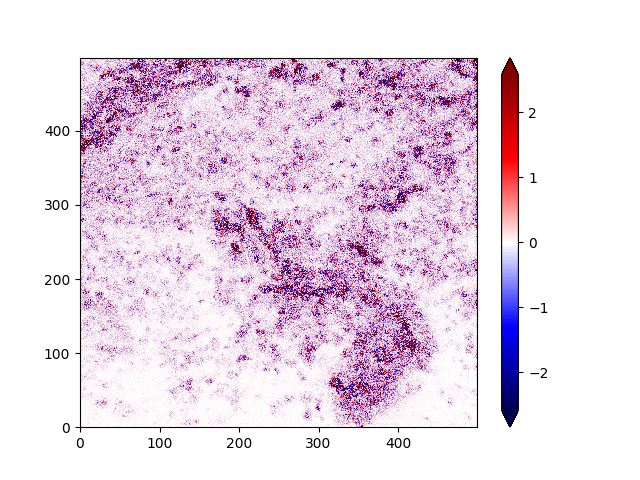

In [95]:
# plot the difference div(flux) + cterm

doblur = False

toplot = cterm + divff

cmap = 'seismic'
bextend = "both"
clims = np.array([-1,1])*4*np.nanstd(toplot)

if doblur:
    toplot = gaussian_filter(toplot, 1, mode='constant')

print("total diff cterm - ...:", np.nansum(toplot*dxf*dyf)/1e9, "GW")

plt.pcolormesh(toplot, vmin=clims[0], vmax=clims[1], cmap=cmap); 
plt.colorbar(extend=bextend)


<IPython.core.display.Javascript object>


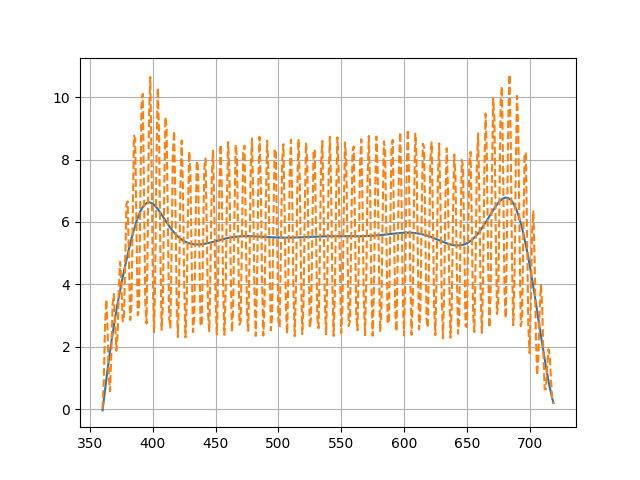

In [96]:
# plot integral of "cterm" and "divf btrop" vesius time
plt.plot(tflu, cterm_lf*dxf*dyf/1e9, tflu, cterm_ts*dxf*dyf/1e9,'--')
plt.grid(True)

In [97]:
# evaluate flux at the boundaries
btouf = (np.nansum(np.diff(Fxlff[[0,-1],:],axis=0)*dyf) \
            + np.nansum(np.diff(Fxlff[:,[0,-1]],axis=1)*dxf)) / 1e9:q
    
btoum = (np.nansum(np.diff(Fxlfm[[0,-1],:],axis=0)*dym) \
            + np.nansum(np.diff(Fxlfm[:,[0,-1]],axis=1)*dxm)) / 1e9
print(btouf, btoum)

25.963481088 2.24081601562e-05
